# Clustering

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [32]:
# Load the PCA-transformed data
pca_df = pd.read_pickle('../data/pca_df.pkl')

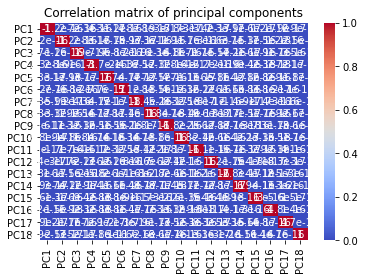

In [33]:
# Plot correlation matrix of principal components
corr_matrix = pca_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of principal components')
plt.show()

### KMeans

In [34]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

KeyboardInterrupt: 

In [35]:
# Helper function to get Betweenss (inter-cluster distance)
def get_betweenss(cluster_model):
    betweenss = 0
    overall_mean = np.mean(pca_df, axis=0)
    for i in range(cluster_model.n_clusters):
        cluster_points = pca_df[cluster_model.labels_ == i]
        cluster_mean = np.mean(cluster_points, axis=0)
        cluster_size = len(cluster_points)
        betweenss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)
    return betweenss


In [36]:
# Calculate cohesion (the lower the better) and separation (the higher the better)
def get_cohesion_and_separation(cluster_model):
    betweenss = get_betweenss(cluster_model)
    withinss = cluster_model.inertia_
    return [withinss/(betweenss + withinss), betweenss/(betweenss + withinss)]

In [37]:
# Allow model comparison with different K values
def compare_models(k_list):
    model_list = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
        cohesion, separation = get_cohesion_and_separation(kmeans)
        print(f"K = {k}, Cohesion = {round(cohesion, 3)}, Separation = {round(separation, 3)}")
        model_list.append(kmeans)
    return model_list

compare_models([5, 10, 15, 20, 25, 30])


K = 5, Cohesion = 0.661, Separation = 0.339
K = 10, Cohesion = 0.535, Separation = 0.465
K = 15, Cohesion = 0.469, Separation = 0.531
K = 20, Cohesion = 0.418, Separation = 0.582
K = 25, Cohesion = 0.386, Separation = 0.614
K = 30, Cohesion = 0.359, Separation = 0.641


[KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=20, random_state=42),
 KMeans(n_clusters=25, random_state=42),
 KMeans(n_clusters=30, random_state=42)]

In [38]:
# Get baseline model and labeled data
kmeans = KMeans(n_clusters=20, random_state=42).fit(pca_df)
kmeans_labeled = pca_df.assign(label=kmeans.labels_)
kmeans_labeled.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,label
0,-5.830959,0.392201,-0.048029,0.891349,0.667314,-0.547912,0.956072,-0.318095,1.822058,-0.094754,0.812422,1.364934,0.589237,0.470023,0.429015,-0.415595,-0.096985,-0.584959,0
1,0.677571,-3.901395,-1.760485,-0.196917,-0.631529,0.520217,-2.870956,1.095125,-0.234196,0.881983,-0.519673,0.222766,0.923846,0.859292,0.841997,-0.096875,0.319600,-0.508862,14
2,-0.042885,2.554052,-1.513229,-1.194602,0.613383,1.918151,0.529408,-0.842260,0.575451,-0.234590,0.569097,-0.738678,0.329163,-2.210941,0.768750,-0.143819,-0.143417,0.294750,10
3,3.708721,1.512710,-0.628712,-0.996156,-1.514873,0.727685,-0.172375,2.248362,1.428215,-2.256918,-0.025042,-0.009935,-0.143695,-0.713426,0.632360,1.043275,1.259287,0.220997,7
4,-0.517309,-0.557434,1.162185,2.123733,0.299534,-0.997618,-0.806662,-0.604398,0.504927,0.118309,1.319696,-0.548108,-0.112941,-0.189817,0.399697,-0.253162,0.104070,-0.088847,6


### Kaggle Submission

In [39]:
# Reorder the laebl and format output for kaggle submission
def format_submission(df, label_col = "label"):
    df = pd.DataFrame(df[label_col])
    label_mapping = {}
    activtyID_list = []
    raw_label = df[label_col].tolist()
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    df["activityID"] = activtyID_list
    df.drop(label_col, axis=1, inplace=True)
    df.to_csv("../data/submission.csv", index=True, index_label=["Index"])

format_submission(kmeans_labeled)